# Road Segmentation notebook

____

<div class="alert alert-block alert-success">
    
### Imports

In [3]:
from matplotlib import pyplot as plt
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from unet import *
from constants import *
from data_preprocess import *
from data_postprocess import *

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [ ]:
PATH_ROOT = ''
DATA_ROOT = PATH_ROOT+'data/'

<div class="alert alert-block alert-warning">

### Load Colab Notebook settings [COLAB]

**Link Google Drive** 

Upload your data `data` on your Google Drive in a directory called `ML`
 with inside subdirectories:

• `train`: with two sub directories of 400x400 images (`images` and `groundtruth`)

• `test`: with 608x608 images

In [33]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH_ROOT = 'gdrive/My Drive/ML/'  #change dir to your project folder
DATA_ROOT = PATH_ROOT+'data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Try GPU power**

In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil, humanize, os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=fbbdd5fd5fc16bdf8d2ec10032e3089cf044e5e922475bf25222b5a6e5ac8cba
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.5 GB  | Proc size: 633.1 MB
GPU RAM Free: 16015MB | Used: 265MB | Util   2% | Total 16280MB


**Kill GPU if not fast enought**

In [ ]:
#!kill -9 -1

### Train model
**1. Split data into validation and training directories**

In [ ]:
data_gen_args = dict(rotation_range=0.15,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')

filepath = "weights.{epoch:02d}-{acc:.2f}.hdf5"
cp_callback = ModelCheckpoint(filepath=filepath, verbose=1, save_weights_only=True, period=1)
model = unet256((SIDE,SIDE,3), verbose=True)
    
for i in range(5):
    # create 5 folds
    create_validation_train_directory(DATA_ROOT+'train/','images','groundtruth', i, 1)
    
    # create train and validation generator
    train_generator = dataGenerator(2, DATA_ROOT+'/train','images_tr','groundtruth_tr',
                                    data_gen_args,(SIDE,SIDE))
    validation_generator = dataGenerator(2, DATA_ROOT+'/train','images_te','groundtruth_te',
                                         data_gen_args,(SIDE,SIDE))
    
    # fit model
    model.fit_generator(generator=train_generator,
                        steps_per_epoch=200,
                        epochs=100,
                        verbose=1,
                        validation_data = validation_generator,
                        validation_steps = 70,
                        validation_freq=10,
                        initial_epoch=0,
                        callbacks=[cp_callback])
    
    metrics = model.evaluate()
    # save model
    save_model(model, PATH_ROOT+"model_saved", "Model_UNET_256_k_fold_"+i)
            
    # 3 predictions?
    reshape_img(DATA_ROOT+"test/", DATA_ROOT+"test_resized/", SIDE)
    data_test = data_load(DATA_ROOT+'test_resized/')
    #model = unet256(input_size = (SIDE,SIDE,3), verbose=False)
    #model.load_weights(PATH_ROOT+"model_saved/Model_UNET_256_k_fold_"+i+".h5")
    results = model.predict(data_test,verbose=1)
               
    if not os.path.exists(DATA_ROOT+"predictions/"):
        os.mkdir(DATA_ROOT+"predictions/")
    
    savePredictedImages(DATA_ROOT+"test_resized/", DATA_ROOT+"predictions/Model_UNET_256_k_fold_"+i, results, concat=False)
    path_from = DATA_ROOT+"predictions/Model_UNET_256_k_fold_"+i+"/"
    path_to = path_from
    reshape_img(path_from, path_to, SIDE_FINAL)

    
original_data = data_load_for_prediction(DATA_ROOT+"test/", RGB_image=True)
IMGS = []
IMGS.append(data_load_for_prediction(DATA_ROOT+"predictions/Model_UNET_256_k_fold_"+str(0)+"/"))
IMGS.append(data_load_for_prediction(DATA_ROOT+"predictions/Model_UNET_256_k_fold_"+str(1)+"/"))
IMGS.append(data_load_for_prediction(DATA_ROOT+"predictions/Model_UNET_256_k_fold_"+str(2)+"/"))
IMGS.append(data_load_for_prediction(DATA_ROOT+"predictions/Model_UNET_256_k_fold_"+str(3)+"/"))
IMGS.append(data_load_for_prediction(DATA_ROOT+"predictions/Model_UNET_256_k_fold_"+str(4)+"/"))
means = average_image(IMGS)
print('Size should be (608, 608) and currently is:',means[0].shape)
index_img = 0
columns = 4
rows = int(len(IMGS))+1

fig=plt.figure(figsize=(10, 2*rows))
img_to_plot = IMGS[0][index_img:index_img+4]
for i in range(1, int(len(IMGS))):
    img_to_plot = np.append(img_to_plot,IMGS[i][index_img:index_img+4], axis=0)
img_to_plot = np.append(img_to_plot, means[index_img:index_img+4], axis=0)
for i in range(1, columns*rows +1):
    img = img_to_plot[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

patched_imgs, vs = patched_imgs_and_vs(means)

fig=plt.figure(figsize=(15, 10))
index_img = 0
columns = 4
rows = 3
img_to_plot0 = means[index_img:index_img+4]
img_to_plot1 =np.append(img_to_plot0, patched_imgs[index_img:index_img+4], axis=0)
for i in range(1, columns*rows +1):
    if(i<=4):
        img = original_data[index_img+i-1]
    else:
        img = img_to_plot1[i-5]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

if not os.path.exists(PATH_ROOT+"submissions/"):
        os.mkdir(PATH_ROOT+"submissions/")
create_csv_submission(patched_imgs, vs, PATH_ROOT+'submissions/test_sub.csv')
    
    
    
    


In [15]:
create_validation_train_directory(DATA_ROOT+'train/',
                                  'images',
                                  'groundtruth', 1)

KeyboardInterrupt: ignored

**2. Data augmentation, generators, callbacks**

In [ ]:
data_gen_args = dict(rotation_range=0.15,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

train_generator = dataGenerator(2, DATA_ROOT+'/train',
                                'images_tr',
                                'groundtruth_tr'
                                ,data_gen_args,
                                (SIDE,SIDE))

validation_generator = dataGenerator(2, DATA_ROOT+'/train',
                                'images_te',
                                'groundtruth_te'
                                ,data_gen_args,
                                (SIDE,SIDE))

filepath = "weights.{epoch:02d}-{acc:.2f}.hdf5"
cp_callback = ModelCheckpoint(filepath=filepath, verbose=1, save_weights_only=True, period=1)

**3. Load the model** 

In [11]:
model = unet256((SIDE,SIDE,3), verbose=True)

















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalizat

**4. Train the model** 

In [13]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=2,#2000
                    epochs=1, #10
                    verbose=1,
                    validation_data = validation_generator,
                    validation_steps = 7,#700
                    #validation_freq=1,
                    initial_epoch=0,
                    callbacks=[cp_callback]
                    )

Epoch 1/1
2/2 [==============================] - 1s 410ms/step - loss: 0.8156 - acc: 0.6402 - f1_m: 0.1931 - val_loss: 3.5169 - val_acc: 0.7818 - val_f1_m: 0.0000e+00

Epoch 00001: saving model to weights.01-0.64.hdf5


### Save model to disk 

In [34]:
save_model(model, PATH_ROOT+"model_saved", "Model_UNET_256_acc99_valid")

Saved model to disk


____

### Predictions

**Load model** 

In [ ]:
json_file = open(PATH_ROOT+'model_saved/Model_UNET_256_acc99_valid.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

**Resize images in a folder** 

In [ ]:
reshape_img(DATA_ROOT+"test/", DATA_ROOT+"test_resized/", SIDE)

**Predict on test images and save the results**  

In [43]:
data_test = data_load(DATA_ROOT+'test_resized/')

test_datagenerator  = ImageDataGenerator()
testGene  = test_datagenerator.flow(data_test, batch_size=1)

model = unet256(input_size = (SIDE,SIDE,3), verbose=False)

model.load_weights(PATH_ROOT+"model_saved/Model_UNET_256_acc99_valid.h5")

results = model.predict(data_test,verbose=1)

if not os.path.exists(DATA_ROOT+"predictions/"):
        os.mkdir(DATA_ROOT+"predictions/")
savePredictedImages(DATA_ROOT+"test_resized/", DATA_ROOT+"predictions/unet_256_99_valida", results, concat=False)
savePredictedImages(DATA_ROOT+"test_resized/", DATA_ROOT+"predictions/unet_256_99_validb", results, concat=True)

Image 50/50 is being loaded
50/50 [==============================] - 2s 41ms/step


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


**Resize image predictions to final size**

In [ ]:
path_from = DATA_ROOT+"predictions/unet_256_99_valida/"
path_to = path_from
reshape_img(path_from, path_to, SIDE_FINAL)

**Load prediction before averaging them** 

In [50]:
original_data = data_load_for_prediction(DATA_ROOT+"test/", RGB_image=True)
IMGS = []
#IMGS.append(data_load_for_prediction(DATA_ROOT+"MEAN/pred_unet_256_97_learning_1e-2a/"))
IMGS.append(data_load_for_prediction(DATA_ROOT+"predictions/unet_256_99_valida/"))

means = average_image(IMGS)
print('Size should be (608, 608) and currently is:',means[0].shape)

Image 50/50 is being loaded
Image 50/50 is being loaded
Size should be (50, 608, 608) and currently is: (50, 608, 608)
Size should be (608, 608) and currently is: (608, 608)


**Plot predictions**

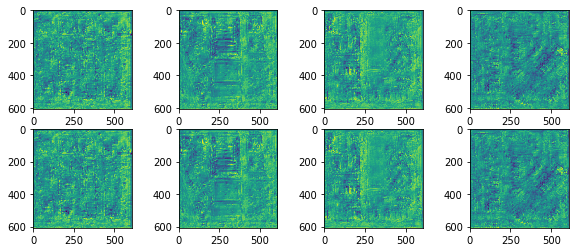

In [51]:
index_img = 0
columns = 4
rows = int(len(IMGS))+1

fig=plt.figure(figsize=(10, 2*rows))
img_to_plot = IMGS[0][index_img:index_img+4]
for i in range(1, int(len(IMGS))):
    img_to_plot = np.append(img_to_plot,IMGS[i][index_img:index_img+4], axis=0)
img_to_plot = np.append(img_to_plot, means[index_img:index_img+4], axis=0)
for i in range(1, columns*rows +1):
    img = img_to_plot[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [52]:
patched_imgs, vs = patched_imgs_and_vs(means)

Image 50/50 is being processed

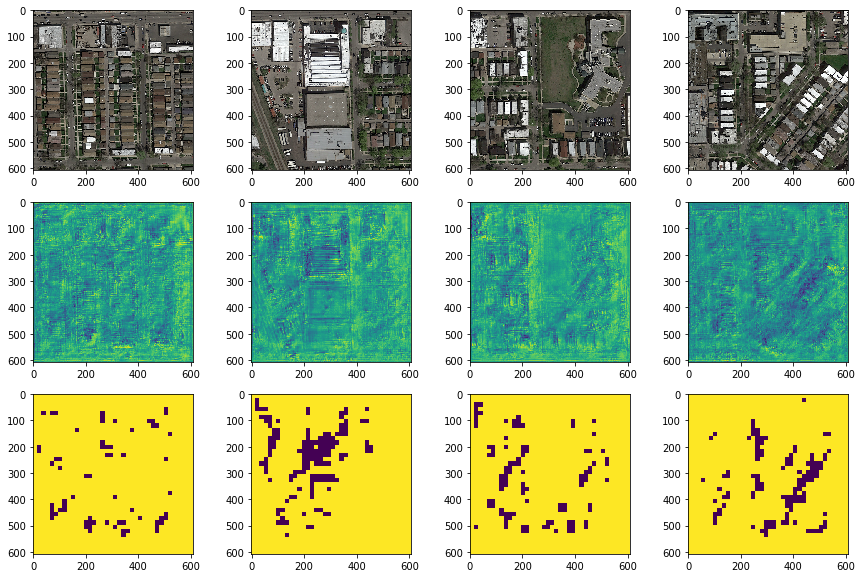

In [53]:
fig=plt.figure(figsize=(15, 10))
index_img = 0
columns = 4
rows = 3
img_to_plot0 = means[index_img:index_img+4]
img_to_plot1 =np.append(img_to_plot0, patched_imgs[index_img:index_img+4], axis=0)
for i in range(1, columns*rows +1):
    if(i<=4):
        img = original_data[index_img+i-1]
    else:
        img = img_to_plot1[i-5]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

**Create submissions**

In [ ]:
if not os.path.exists(PATH_ROOT+"submissions/"):
        os.mkdir(PATH_ROOT+"submissions/")
create_csv_submission(patched_imgs, vs, PATH_ROOT+'submissions/test_sub.csv')